In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Task: First part is segment the respiratory cycles from the audio files respectively and annotate it accordingly**



# Introduction
Deployment is the end goal of any Machine-Learning based project. Whilst this dataset provides conveniently labelled timings of each breathing cycle to train ML based models, extracting similar timings from new audio clips for a trained model remains an unresolved issue.

This notebook strives to produce an automated method of extracting breathing cycle timings from audio clips for ML model training, as well as to generate the input data for a deployed ML model.

The crux of the method revolves around peak detection of the sound intensity envelop. Estimates of the start and end of each breathing cycle are then fine-tuned using data from the hand-annotated breathing cycles. The following is a rough breakdown of the steps:

Peak Extraction

Noise Removal(Bandpass Filtering) + Log Compression
Computation of Intensity envelop from spectrogram
Peak detection of Guassian-smoothed peak intensity envelop (Left/Right Base of peaks also recorded)
Breathing Cycle Start/End Estimate

Represent the start/end of each cycle as the left/right base of each extracted peak with an outward offset
Among the detected peaks, use a min-weight Bipartite match to match peaks with the closest hand-annotated breathing cycle (Each cycle may only be paired with 1 peak, unpaired peaks are ignored)
Perform multivariate optimization to find the appropriate offset values to minimize the mean error of each start/end cycle with the paired hand-annotated breathing cycle timings.
After performing these steps, peaks may be extracted by finding a peak and the timing of the left & right bases. An audio clip is extracted from the left / right base with the offset found above added to get an audio clip of a breathing cycle.

For training data, labels can be transferred to the automatically detected cycle timings via Intersection over Union metrics.

In [ ]:

'''
 This piece code helps us in just to read all audio and text files asociated with that audio file
 so we have total 724 audio files and 724 txt files
'''
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

audioFilePaths = []
recordingInfoFilePaths = []
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Hackathon_AIOSP2022/Hackathon/audio_and_txt_files'):
    for filename in filenames:
        fullPath = os.path.join(dirname, filename)
        if filename.endswith("wav"):
            audioFilePaths.append(fullPath)
        elif filename.endswith("txt"):
            recordingInfoFilePaths.append(fullPath)
        #print(os.path.join(dirname, filename))

print("Number of Audio Files: ",len(audioFilePaths))
print("Number of Text Files: ",len(recordingInfoFilePaths))

Number of Audio Files:  724
Number of Text Files:  724


In [ ]:
import csv
'''
Define a function to get Exact file name but without extention
INPUT:  "fullpath" is nothing but Path directory
OUTPUT: and this function Returning only file name without the path directory

'''
def extractFilenameWithoutExtension(fullPath):
    fileName = os.path.basename(fullPath)
    fileNameWithoutPath = os.path.splitext(fileName)[0]
    return fileNameWithoutPath


'''
SO, in this function we are creation  a dictionary in which we have
#(fullPaths:string[]) => dict<filename:string, (start, end, hasCrackles, hasWheezes)[]>
from every text file out there
input: Path list

'''

#(fullPaths:string[]) => dict<filename:string, (start, end, hasCrackles, hasWheezes)[]>
def getFileInfoDict(pathList):
    fileInfoDict = {}
    for path in pathList:
        fileNameWithoutPath = extractFilenameWithoutExtension(path) # callling fuction and storing file name without path
        infoList = []
        with open(path, 'r') as hFile:
            reader = csv.reader(hFile, delimiter='\t')
            for row in reader:
                startTime = float(row[0])
                endTime = float(row[1])
                hasCrackles = True if int(row[2]) == 1 else False
                hasWheezes = True if int(row[3]) == 1 else False
                infoList.append((startTime, endTime, hasCrackles, hasWheezes))

        fileInfoDict[fileNameWithoutPath] = infoList
    return fileInfoDict





audioFilePathsWithoutExtension = [extractFilenameWithoutExtension(path) for path in audioFilePaths]
fileInfoDict = getFileInfoDict(recordingInfoFilePaths)
#List order is aligned with the order in which the audio clips are extracted
fileInfoList = [fileInfoDict[audioPath] for audioPath in audioFilePathsWithoutExtension]


#print(fileInfoList,"\n\n\n\n\n\n\n")
#print(fileInfoDict,"\n\n\n\n\n\n")

# Basic Pre-processing
All audio files are resampled to 7000Hz. The resultant Nyquist frequency is covers the range for lung sounds (25-1500Hz [1]).

Due to the prevalance of handling noise (bumps/knocks), which manifest as Low-Frequency noise, a brick-wall high pass filter of 80Hz is applied.

Log Compression is then used to reduce the differences in dynamic range within the audio clips.

In [ ]:
import librosa # for Dealing with audio signals

gSampleRate = 7000



def loadFiles(fileList):
    outputBuffers = []
    for filename in fileList:
        audioBuffer, nativeSampleRate = librosa.load(filename, dtype=np.float32, mono=True, sr=None)
        if nativeSampleRate == gSampleRate:
            outputBuffers.append(audioBuffer)
        else:
        #Linear resampling using numpy is significantly faster than Librosa's default technique
            duration = len(audioBuffer) / nativeSampleRate
            nTargetSamples = int(duration * gSampleRate)
            timeXSource = np.linspace(0, duration, len(audioBuffer), dtype=np.float32)
            timeX = np.linspace(0, duration, nTargetSamples, dtype=np.float32)
            resampledBuffer = np.interp(timeX, timeXSource, audioBuffer)
            outputBuffers.append(resampledBuffer)

    return outputBuffers

audioBuffers = loadFiles(audioFilePaths)

/usr/local/lib/python3.7/dist-packages/resampy/interpn.py:114: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  _resample_loop_p(x, t_out, interp_win, interp_delta, num_table, scale, y)


In [ ]:
from scipy import signal
import matplotlib.pyplot as plt

upperCutoffFreq = 3000
cutoffFrequencies = [80, upperCutoffFreq]

#FIR coefficients for a bandpass filter with a window of 80-3000 Hz
highPassCoeffs = signal.firwin(401, cutoffFrequencies, fs=gSampleRate, pass_zero="bandpass")

def applyHighpass(npArr):
    return signal.lfilter(highPassCoeffs, [1.0], npArr)

#Higher gamma results in more aggressive compression
def applyLogCompressor(signal, gamma):
    sign = np.sign(signal)
    absSignal = 1 + np.abs(signal) * gamma
    logged = np.log(absSignal)
    scaled = logged * (1 / np.log(1.0 + gamma)) #Divide by the maximum possible value from compression
    return sign * scaled

#Scales all samples to ensure the peak signal is 1/-1
def normalizeVolume(npArr):
    minAmp, maxAmp = (np.amin(npArr), np.amax(npArr))
    maxEnv = max(abs(minAmp), abs(maxAmp))
    scale = 1.0 / maxEnv
    #in place multiply
    npArr *= scale
    return npArr

#Removing the low-freq noise, re-normalizing volume then apply compressor
noiseRemoved = [normalizeVolume(applyHighpass(buffer)) for buffer in audioBuffers]
noiseRemoved = [applyLogCompressor(sig, 30) for sig in noiseRemoved]

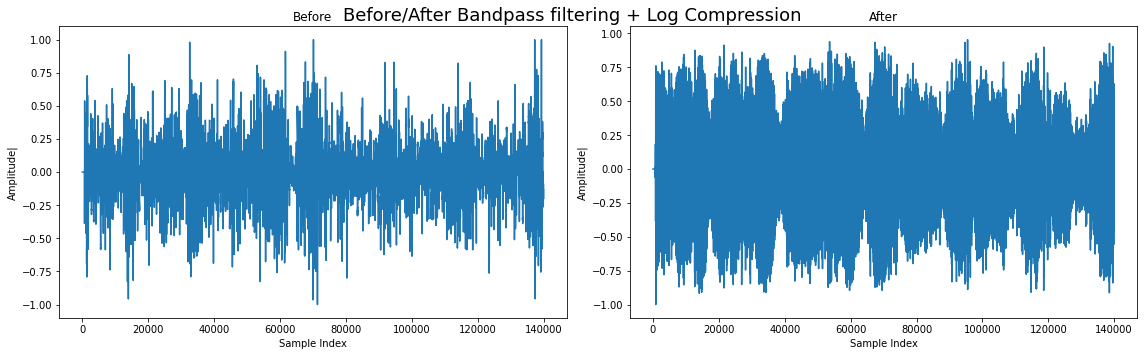

Before Filtering


Post Filtering


In [ ]:
import IPython.display as ipd

fig, axs = plt.subplots(1,2, figsize=(16,5))

selectedSampleIdx = 19

fig.suptitle('Before/After Bandpass filtering + Log Compression', fontsize=18)

axs[0].plot(audioBuffers[selectedSampleIdx])
axs[0].set_title("Before")

axs[1].plot(noiseRemoved[selectedSampleIdx])
axs[1].set_title("After")

for ax in axs.flat:
    ax.set(ylabel='Amplitude|', xlabel='Sample Index')

plt.tight_layout()
plt.show()

print("Before Filtering")
ipd.display(ipd.Audio(audioBuffers[selectedSampleIdx], rate=gSampleRate))
print("Post Filtering")
ipd.display(ipd.Audio(noiseRemoved[selectedSampleIdx], rate=gSampleRate))

# Peak detection from Spectrograms

Spectrograms are generated using a FFT window size of 50ms. The resultant bins in the spectrogram are multiplied by the square of their frequency, as the power of a sound wave is given by the following relation:
 p = Amplitude^2 * Frequency^2


 The amplitude square relation is ignored in this case since omitting it results in cleaner peaks.
To filter out transients (i.e. knocks), a Guassian filter is used to smooth out the curve. Peak detection is then performed on the smoothed curve. The timings corresponding to the left/ right bases (relative to 80% of peak height) of each peak are then recorded.

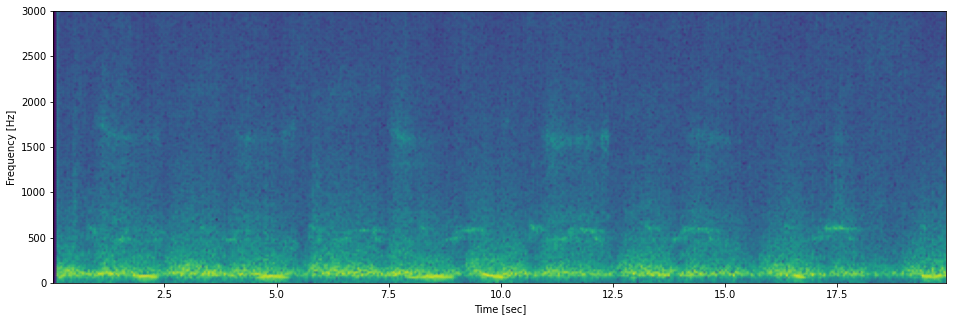

In [ ]:
windowSizeSeconds = 0.05
windowSampleSize = int(gSampleRate * windowSizeSeconds)



def plotSpectrogram(specData):
    plt.figure(figsize=(16,5))
    #Gamma scaling factor of 0.1 needed to make spectrogram more readable
    plt.pcolormesh(specData[1], specData[0], np.power(specData[2],0.1) , shading='gouraud')
    plt.ylim(0, upperCutoffFreq)
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()

#(audioBuffers:float[][]) => (frequencies:float[], time(seconds):float[], amplitudes:float[][]))[]
def getSpectrograms(audioBuffers):
    spectrograms = []
    for buffer in audioBuffers:
        freqTable, times, powerSpectrum = signal.spectrogram(buffer, gSampleRate, nperseg=windowSampleSize)
        spectrograms.append((freqTable, times, powerSpectrum))
    return spectrograms

spectrograms = getSpectrograms(noiseRemoved)
plotSpectrogram(spectrograms[selectedSampleIdx])

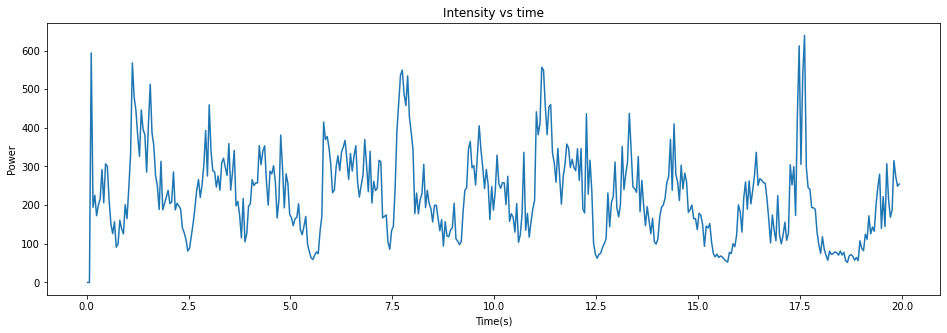

In [ ]:
#(spectrogram:float[][], cutoffFreq(hz):float, plot:bool) => (times:float, amplitudes:float[])
def getPowerEnvelop(spectrogram, cutoff, plot=False):
    frequencies = spectrogram[0]
    timeSlices = spectrogram[1]
    spectrum = spectrogram[2]

    maxInd = np.sum(frequencies <= cutoff)
    truncFreq = frequencies[:maxInd]

    powerEnvelop = []
    for idx, _ in enumerate(timeSlices):
        freqAmplitudes = spectrum[:maxInd,idx]

        powerBins = freqAmplitudes * np.square(truncFreq)
        powerEnvelop.append(sum(powerBins))
    if (plot):
        plt.figure(figsize=(16,5))
        plt.title("Intensity vs time")
        plt.plot(timeSlices, powerEnvelop)
        plt.xlabel("Time(s)")
        plt.ylabel("Power")
        plt.show()

    return (timeSlices, powerEnvelop)

time, amp = getPowerEnvelop(spectrograms[selectedSampleIdx], upperCutoffFreq, True)

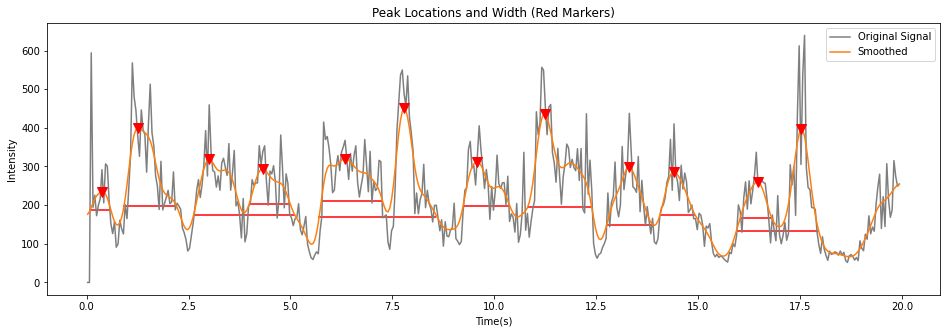

In [ ]:
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
from scipy.signal import peak_widths
import math

#(amplitudes:float[], time(seconds):float[], sampleInterval(seconds):float, minPeakDuration(seconds):float, gaussainSmoothingSigma:float, peakRelHeight(0-1):float, plot:bool) =>
#(smoothed:float[], peakTiming(seconds):float[], leftRightBoundaries:(left(seconds):float, right(seconds):float)[])
def findPeaksAndWidthsFromSmoothedCurve(amplitudes,time, sampleInterval, minPeakDuration=0.4, gaussianSmoothingSigma = 3, peakRelHeight=0.8, plot=False):
    smoothed = gaussian_filter1d(amplitudes, gaussianSmoothingSigma)
    minPeakDurationSamples = int(math.ceil(minPeakDuration / sampleInterval))
    peakIndices, _ = find_peaks(smoothed, width=minPeakDurationSamples)
    peakWidthResult = peak_widths(smoothed, peakIndices, peakRelHeight)

    leftPeakTimes = time[np.rint(peakWidthResult[2]).astype(int)]
    rightPeakTimes = time[np.rint(peakWidthResult[3]).astype(int)]
    leftRightBoundaries = list(zip(leftPeakTimes, rightPeakTimes))

    peakTiming = time[peakIndices]
    if plot:
        plt.figure(figsize=(16,5))
        plt.plot(time, amplitudes, color="tab:gray", label="Original Signal")
        plt.plot(time, smoothed, color="tab:orange", label="Smoothed")
        plt.plot(peakTiming, smoothed[peakIndices], "v", color="red", markersize=10)
        plt.hlines(peakWidthResult[1], leftPeakTimes , rightPeakTimes , color="red")
        plt.xlabel("Time(s)")
        plt.ylabel("Intensity")
        plt.title("Peak Locations and Width (Red Markers)")
        plt.legend()
        plt.show()

    return (smoothed, peakTiming, leftRightBoundaries)


_  = findPeaksAndWidthsFromSmoothedCurve(amp, time, windowSizeSeconds, plot=True)

In [ ]:
#Calulate power envelop from sepctrogram
#(time(s):float[], amp:float[])
powerEnvelops = [getPowerEnvelop(spectrogram, upperCutoffFreq, False) for spectrogram in spectrograms]

#print(powerEnvelops)

In [ ]:
from sklearn.model_selection import train_test_split

trainIndices, testIndices = train_test_split(range(len(recordingInfoFilePaths)), test_size=0.2, random_state=0xDEADBEEF)

def multiIndexList(sourceList, indices):
    return [obj for idx, obj in enumerate(sourceList) if idx in indices]

trainFileNames = multiIndexList(audioFilePathsWithoutExtension, trainIndices)
testFileNames = multiIndexList(audioFilePathsWithoutExtension, testIndices)

In [ ]:
#Peak identification from power envelop
#(smoothedSignal:float[], peakTiming:seconds[], peakLeftRightBoundaries:(left:float,right:float)[])[]
peakData = [findPeaksAndWidthsFromSmoothedCurve(amp, time, windowSizeSeconds) for time, amp in powerEnvelops]
trainPeakData =  multiIndexList(peakData, trainIndices)
testPeakData =  multiIndexList(peakData, testIndices)

# Obtaining the left/right offsets for each breathing cycle
The left/right peak bases will be used as the reference for start/end of a breathing cycle. A constant offset for the left and right base will be applied to estimate the starting/ending times of the breathing cycle.

Breathing Cycle
start
=
Peak Base
left
−
Offset
left

Breathing Cycle
end
=
Peak Base
right
+
Offset
right


The values for {
Offset
left
,
Offset
right
}
  will be found by finding the value that minimizes error between the estimated start/end of each breathing cycle with the hand-annotated dataset. A multivariate optimization funciton is used to search for the offset values, with the objective function function being the sum of the mean errors of the start/end time between the estimated and hand-annotated cyles.

As there are more detected peaks than hand-annotated cycles, only the peaks that are closest to the hand-annotated cycles will be used for comparison. Unpaired peaks are not considered in the objective funciton. The metric for closeness to a hand-annoated cycle will be the time difference between the peak and the middle of the hand-annotated cycle. A min-weight bipartite search is used for the pairing process.

To prove that this method generalizes well to the entire dataset, a train-test-split (test=20%) methodology was adopted, where the offset values found using the training dataset are then evaluated by comparing the mean left/right boundary errors within the test dataset.

In [ ]:
#Compare the difference between the middle of the detected cycle and the middle of the closest hand-annotated cycle
#Repeat for the left/right boundaries as well
#This will be used to fudge the boundaries to tune the left/right padding values.
from scipy.sparse.csgraph import min_weight_full_bipartite_matching
from scipy.sparse import csr_matrix

#(handAnnotatedCentres: float(seconds)[], autoExtractedCentes:float(seconds)[]) => (handAnnotatedIndices:int[], autoExtractedIndices:int[])
#matches the auto-extracted centres with the hand-annotated centres. Each point can only be matched once
#(i.e. one hand-annotated centre will not be matched with more than 1 auto-extracted centre)
def bipartiteMatchWithClosestCentres(handAnnotatedCentres, autoExtractedCentes):
    nRows = len(autoExtractedCentes)
    nCols = len(handAnnotatedCentres)
    weights = np.zeros((nRows, nCols))

    handAnnotatedArr = np.array(handAnnotatedCentres)
    #compute euclidean distance (1-D)
    for row, extractedCentre in enumerate(autoExtractedCentes):
        #Add 1 since the bipartite match requires non-zero weights
        distVec = np.abs(np.subtract(handAnnotatedArr, extractedCentre)) + 1
        weights[row, :] = distVec

    weightsCSR = csr_matrix(weights)

    matchedRows, matchedCols = min_weight_full_bipartite_matching(weightsCSR)
    #(handAnnotatedIndices:int[], autoExtractedIndices:int[])
    return (matchedCols, matchedRows)

In [ ]:
def calculateBoundaryError(audioFileName, autoDetectedPeaks, paddingTime):
    leftBoundaryDiff = []
    rightBoundaryDiff = []
    centreDiffList = []

    for filename, autoPeakInfo in zip(audioFileName, autoDetectedPeaks):
        #Get boundaries from hand-annotated cycles
        handAnnotatedInfo = fileInfoDict[filename]
        handAnnLeft = np.array([info[0] for info in handAnnotatedInfo])
        handAnnRight = np.array([info[1] for info in handAnnotatedInfo])
        handAnnCentre = np.array([(info[0] + info[1]) * 0.5 for info in handAnnotatedInfo])

        #Get centres form automatically extracted cycles
        leftRightBoundaries = autoPeakInfo[2]
        autoLeft = np.array([left - paddingTime[0] for left, _ in leftRightBoundaries])
        autoRight = np.array([right + paddingTime[1] for _, right in leftRightBoundaries])
        autoCentre = np.array([0.5 * (left + right) for left, right in zip(autoLeft, autoRight)])

        #Min. Bipartite Match the centres to pair the most appropriate auto-extracted centre to a hand-annotated centre
        handAnnIndices, autoExtractedIndices = bipartiteMatchWithClosestCentres(handAnnCentre, autoCentre)

        #Now compute the diff. for each cycle extracted from peak-detection.
        #diff from ground truth (<ground-truth> - <peak-detection-method>),
        #-ve values mean the peak detection method detects later than the ground truth (appear right on the graphs)
        leftDiff = np.subtract(handAnnLeft[handAnnIndices], autoLeft[autoExtractedIndices])
        rightDiff = np.subtract(handAnnRight[handAnnIndices], autoRight[autoExtractedIndices])
        centreDiff = np.subtract(handAnnCentre[handAnnIndices], autoCentre[autoExtractedIndices])

        leftBoundaryDiff += leftDiff.tolist()
        rightBoundaryDiff += rightDiff.tolist()
        centreDiffList += centreDiff.tolist()

    return (leftBoundaryDiff, rightBoundaryDiff, centreDiffList)

#Values to be iteratively fine-tuned using the hand-annotated data via the method shown below
paddingTimeInit = (0.305, 1.391) #Note, this has already been refined by the optimizer

boundaryDiff = calculateBoundaryError(trainFileNames, trainPeakData, paddingTimeInit)

In [ ]:
def plotBoundaryErrorSummary(overallCaption, leftBoundaryDiff, rightBoundaryDiff, centreDiffList):
    nBins = 50
    fig, axs = plt.subplots(3, figsize=(6,10))
    fig.suptitle(
        overallCaption +
        '\nError Values between ground truth and detected boundaries\n(-ve values indicate detected boundaries are late)\n'
        , fontsize=18
    )

    axs[0].hist(leftBoundaryDiff, nBins)
    axs[0].set_title("Left boundary error (Ground Truth - Detected)")
    axs[0].set_xlim([-5, 5])

    axs[1].hist(rightBoundaryDiff, nBins)
    axs[1].set_title("Right boundary error (Ground Truth - Detected)")
    axs[1].set_xlim([-5, 5])

    axs[2].hist(centreDiffList, nBins)
    axs[2].set_title("Cycle Centre error (Ground Truth - Detected)")
    axs[2].set_xlim([-5, 5])

    for ax in axs.flat:
        ax.set(xlabel='Error(seconds)', ylabel='No. of instances')

    plt.tight_layout()
    plt.show()

    print("-Mean Errors-\nLeft Boundary:{0}\nRight Boundary:{1}\nCentre:{2}"
          .format(np.mean(leftBoundaryDiff), np.mean(rightBoundaryDiff),np.mean(centreDiffList)))

#plotBoundaryErrorSummary("[Training Set]", *boundaryDiff)

**Note:** The multivariate optimizer has already been run for a multiple cycles to produce "paddingTimeInit". Given that each evaluation of the objective function requires multiple bipartite matches across the entire dataset, it takes quite a while to run even for a few iterations. It has been commented out to save time.

In [ ]:
from scipy.optimize import minimize

def boundaryErrorObj(leftRight):
    leftDiff, rightDiff, _ = calculateBoundaryError(trainFileNames, trainPeakData, leftRight)
    return np.abs(np.sum(leftDiff)) + np.abs(np.sum(rightDiff)) #i.e. make the means as close to 0 as possible

#optimalPaddingRes = minimize(boundaryErrorObj, paddingTimeInit, method=’BFGS’,  options={'disp':True, 'maxiter':1})
#optimalPadding = optimalPaddingRes.x
optimalPadding = paddingTimeInit #Value already optimized, commented lines above to save time.
print(optimalPadding)

(0.305, 1.391)


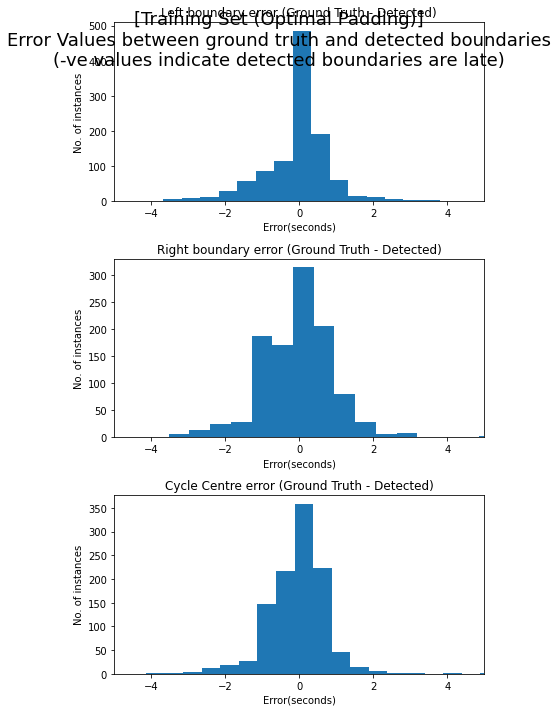

-Mean Errors-
Left Boundary:-0.0011436990965040693
Right Boundary:-0.0241049587534372
Centre:-0.01262432892497066


In [ ]:
boundaryDiffOptimal = calculateBoundaryError(testFileNames, testPeakData, optimalPadding)
plotBoundaryErrorSummary("[Training Set (Optimal Padding)]",
                         *boundaryDiffOptimal)


# Validation of the offset values
The Left/Right boundary errors are still mainly centred around 0s, with the mean errors also being fairly small (on the order of  

10
−
4




  seconds), indicating that fitting a simple constant to the training set yields results that generalize well.

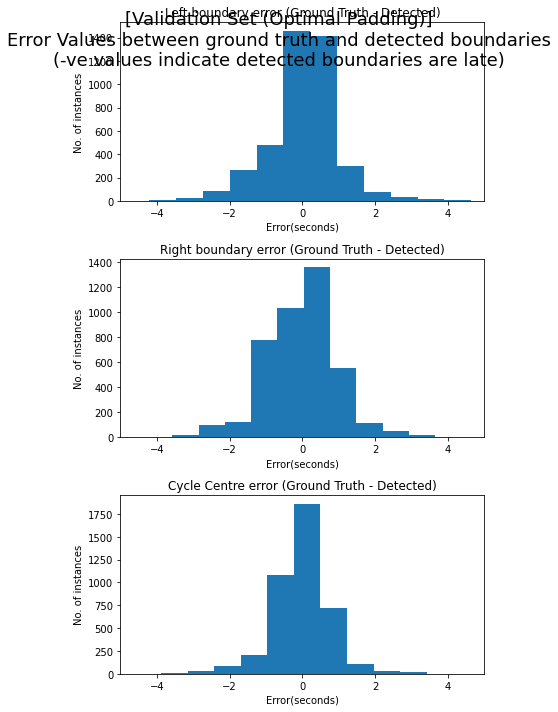

-Mean Errors-
Left Boundary:0.026739685392488916
Right Boundary:-0.04016969292389856
Centre:-0.006715003765704784


In [ ]:
boundaryDiffOptimalValidation = calculateBoundaryError(trainFileNames, trainPeakData, optimalPadding)
plotBoundaryErrorSummary("[Validation Set (Optimal Padding)]", *boundaryDiffOptimalValidation)

No. of cycles from Hand Annotation:5520
No. of cycles from Peak Detection:7993
95th Percentile of Peak Detection Cycle Lengths:3.76s


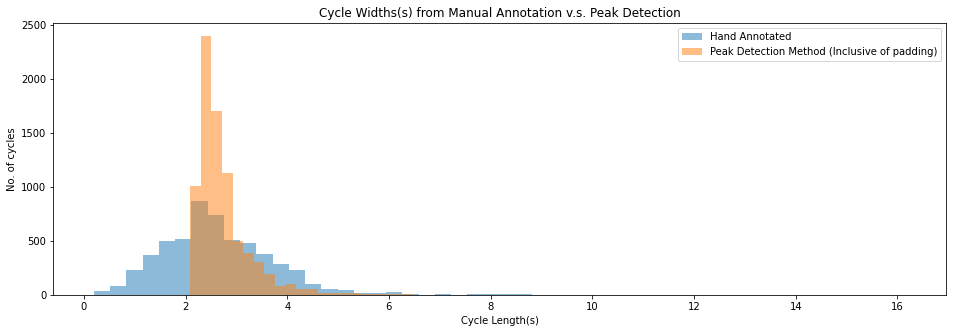

In [ ]:
#Comparison between distribution of detected cycle times.
handAnnotatedWidths = []
for _, cycleInfoList in fileInfoDict.items():
    for cycleInfo in cycleInfoList:
        handAnnotatedWidths.append(cycleInfo[1] - cycleInfo[0])

peakDetectionWidths = []
for peaks in peakData:
    paddingOffset = sum(optimalPadding) #The times are before the left/right pads are added to the sample, re-add pad to get actual extracted length
    for leftRightBoundary in peaks[2]:
        peakDetectionWidths.append(leftRightBoundary[1] - leftRightBoundary[0] + paddingOffset)

print("No. of cycles from Hand Annotation:{0}".format(len(handAnnotatedWidths)))
print("No. of cycles from Peak Detection:{0}".format(len(peakDetectionWidths)))
print("95th Percentile of Peak Detection Cycle Lengths:{:.2f}s".format(np.percentile(peakDetectionWidths, 95)))

nBins = 50
plt.figure(figsize=(16,5))
plt.hist(handAnnotatedWidths, nBins, alpha=0.5, label='Hand Annotated')
plt.hist(peakDetectionWidths, nBins, alpha=0.5, label='Peak Detection Method (Inclusive of padding)')
plt.title("Cycle Widths(s) from Manual Annotation v.s. Peak Detection")
plt.ylabel("No. of cycles")
plt.xlabel("Cycle Length(s)")
plt.legend(loc='upper right')
plt.show()

In [ ]:
def clamp(val, lowerInclusive, upperInclusive):
    if val > upperInclusive:
        return upperInclusive
    elif val < lowerInclusive:
        return lowerInclusive
    else:
        return val

#(timeSegments:(left_seconds:float, right_seconds:float), audioSamples:float[], sampleRate:int) => float[][]
def sliceAudio(timeSegments, audioSamples, sampleRate):
    maxSampleIdx = len(audioSamples) - 1
    segments = []
    for boundaries in timeSegments:
        left = clamp(int(boundaries[0] * sampleRate), 0, maxSampleIdx)
        right = clamp(int(boundaries[1] * sampleRate), 0, maxSampleIdx)
        segments.append(audioSamples[left:right])
    return segments

#(rawAudio:float[],
# peakInfo:(smoothedSignal:float[], peakTiming:seconds[], peakLeftRightBoundaries:(left:float,right:float)[]),
# padding:(left:float, right:float),
# sampleRate:int)
#   => (audioClips:float[][], peakTimes:float[], leftRightBoundaries:(float,float)[])
def extractAudioWithPeakInfo(rawSignal, peakInfo, padding, sampleRate):
    maxSampleIdx = len(rawSignal) - 1
    maxTime = maxSampleIdx * sampleRate
    leftPadding, rightPadding = padding
    leftRightBoundaries = [(clamp(left - leftPadding, 0, maxTime), clamp(right + rightPadding, 0, maxTime)) for left, right in peakInfo[2]]
    audioSegments = sliceAudio(leftRightBoundaries, rawSignal, sampleRate)
    return (audioSegments, peakInfo[1], leftRightBoundaries)

#Get sample slices
#(audioClips:float[][], peakTimes:float[], leftRightBoundaries:(float,float)[])[]
extractedAudioClips = [extractAudioWithPeakInfo(signal, peakInfo, optimalPadding,gSampleRate) for signal, peakInfo in zip(noiseRemoved, peakData)]

# **Results**
Have a listen to some of the automatically extracted clips. This method works reasonably well when the audio source isn't flooded with noise, but tends to generate overlapping clips for noiser sources.

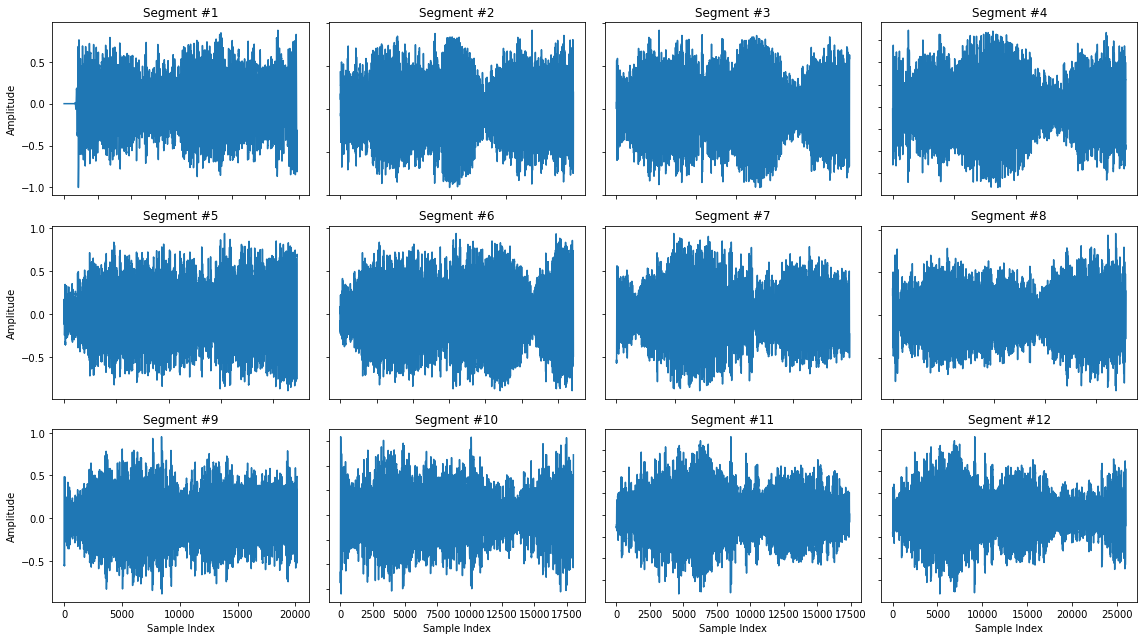

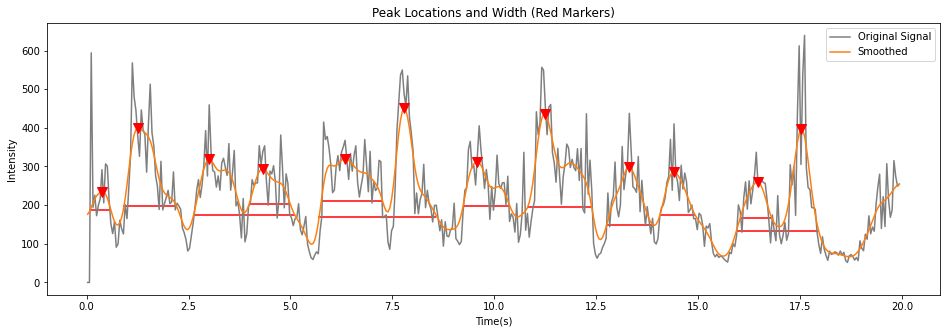

Original


Segment #1


Segment #2


Segment #3


Segment #4


Segment #5


Segment #6


Segment #7


Segment #8


Segment #9


Segment #10


Segment #11


Segment #12


In [ ]:
def plotAllSamples(audioSegments):
    nPlots = len(audioSegments)
    cols = int(math.ceil(math.sqrt(nPlots)))
    rows = math.ceil(nPlots / cols)
    fig, axs = plt.subplots(rows, cols, figsize=(16,9))
    for idx, sample in enumerate(audioSegments):
        row = idx // cols
        col = idx % cols
        ax = axs[row, col]
        ax.plot(sample)
        ax.set_title("Segment #{0}".format(idx + 1))

    for ax in axs.flat:
        ax.set(xlabel='Sample Index', ylabel='Amplitude')

    for ax in axs.flat:
        ax.label_outer()

    plt.tight_layout()
    plt.show()

#plotAllSamples(onlyPeaks)
idx = 19
selectedClip = extractedAudioClips[idx][0]
plotAllSamples(selectedClip)
time, amp = getPowerEnvelop(spectrograms[idx], upperCutoffFreq, False)
_  = findPeaksAndWidthsFromSmoothedCurve(amp, time, windowSizeSeconds, plot=True)
print("Original")
ipd.display(ipd.Audio(audioBuffers[idx], rate=gSampleRate))
for i in range(len(selectedClip)):
    print("Segment #{0}".format(i + 1))
    ipd.display(ipd.Audio(selectedClip[i], rate=gSampleRate))

# Transfer of labels
Dataset labels for the presence of crackles/wheezes can be transferred using an intersection over union approach(IoU).

If the extracted sample entirely covers a hand-annotated label with a positive crackle/wheeze label, it will assume the label of the hand-annotated cycle. Otherwise, positive labels will only be copied if the IoU between the estimated cycle and hand annotated label is greater than 50%.

In [ ]:
#(containingRegion:(left:float,right:float), targetRegion:(left:float,right:float)) => overlapFrac(0-1):float
def getOverlapFrac(containingRegion, targetRegion):
    overlap = max(0, min(containingRegion[1], targetRegion[1]) - max(containingRegion[0], targetRegion[0]))
    overlapFrac = overlap / (targetRegion[1] - targetRegion[0])
    return overlapFrac



def fracOfSampleCovered(groundTruth, autoDetectedWindow):
    overlap = max(0, min(groundTruth[1], autoDetectedWindow[1]) - max(groundTruth[0], autoDetectedWindow[0]))
    fracOfSampleCovered = overlap / (groundTruth[1] - groundTruth[0])
    return fracOfSampleCovered


#Applying labels to auto-extracted data
#(hand-annotated-labels:(start, end, hasCrackles, hasWheezes)[], auto-extracted-segments:(left,right)[], minOverlapFrac(0-1):float) =>
#transfered-labels:(left,right, hasCrackles, hasWheezes)[]
#Any segment where the overlap ratio with a hand annotated segment is more than <minOverlapFrac> will have the crackles/wheezes label applied
#minOverlapFrac is defined as the intersection between the hand-annotated segment and auto-detected segment, divided by the size of the auto-detected segment


def transferLabelToExtractedSegment(handAnnotation, automaticSegmentTimes, minOverlapFrac):
    transferredLabels = []
    handAnnotatedSegments = [(left, right) for left, right, _ , _ in handAnnotation]
    handAnnotatedLabels = [(hasCrackles, hasWheezes) for _, _, hasCrackles, hasWheezes in handAnnotation]
    for autoSegment in automaticSegmentTimes:
        overlapFractions = [getOverlapFrac(groundTruth, autoSegment) for groundTruth in handAnnotatedSegments]
        fracOfAnnSampleCovered = [fracOfSampleCovered(groundTruth, autoSegment) for groundTruth in handAnnotatedSegments]
        allSelectedLabels = [labels if (oFrac > minOverlapFrac or sFrac > minOverlapFrac) else (False, False) for oFrac, sFrac, labels in zip(overlapFractions,fracOfAnnSampleCovered, handAnnotatedLabels)]
        hasCrackles = any([bCrackles for bCrackles, _ in allSelectedLabels])
        hasWheezes = any([bWheezes for _, bWheezes in allSelectedLabels])
        transferredLabels.append((*autoSegment, hasCrackles, hasWheezes))
    return transferredLabels

#illustrative purposes
testIdx = 0
handAnnotations = fileInfoList[testIdx]
autoExtractedSegments = extractedAudioClips[testIdx][2]
print(handAnnotations)
#print(autoExtractedSegments)
print(transferLabelToExtractedSegment(handAnnotations, autoExtractedSegments, 0.5))

[(0.864, 4.656, False, False), (4.656, 8.75, False, False), (8.75, 13.331, False, False), (13.331, 17.81, False, False), (17.81, 19.337, False, False)]
[(0.5971428571428572, 3.0825714285714287, False, False), (2.0444285714285715, 4.661428571428571, False, False), (3.4478571428571425, 5.714, False, False), (4.412714285714286, 6.678857142857143, False, False), (5.421428571428572, 7.687571428571428, False, False), (8.798428571428571, 11.152285714285714, False, False), (10.28957142857143, 13.432857142857143, False, False), (13.359571428571428, 15.71342857142857, False, False), (14.850714285714286, 17.643142857142855, False, False), (17.789142857142856, 20.274571428571427, False, False)]


In [ ]:
#Apply annotation transfer to all cycles.

#(handAnnotationList:(start, end, hasCrackles, hasWheezes)[],
# autoSegmentList:(audioClips:float[][], peakTimes:float[], leftRightBoundaries:(float,float)[])[],
# minOverlapFrac:float) =>
#    autoSegmentWithLabels(audioClips:float[][], peakTimes:float[], cycleInfo:(float,float, hasCrackles, hasWheezes)[])[]
def transferLabels(handAnnotationList, autoSegmentList, minOverlapFrac):
    autoSegmentWithTransferLabels = []
    for handAnn, autoSeg in zip(handAnnotationList,autoSegmentList):
        xferredLabels = transferLabelToExtractedSegment(handAnn, autoSeg[2], minOverlapFrac)
        autoSegmentWithTransferLabels.append((autoSeg[0], autoSeg[1], xferredLabels))
    return autoSegmentWithTransferLabels

minOverlapFrac = 0.5
transferredLabels = transferLabels(fileInfoList, extractedAudioClips, minOverlapFrac)



# print(transferredLabels)

